# Thick Sample Ptychography Forward Model Tutorial 2D

This tutorial demonstrates how to use `thickptypy` to set up and solve a 2D forward problem with multiple probes, both iteratively and as a full system.


The forward model solves the paraxial equation:

\begin{equation}
\frac{\partial u}{\partial z} = a \frac{\partial^2 u}{\partial x^2}  + C(x, z) u,
\end{equation}
where
\begin{equation}
a := \frac{1}{2ik} \qquad \text{and} \qquad C(x, z) := \frac{k}{2i} \left(n^2(x, z) - 1\right)
\end{equation}


**$n$ defines the refractive index of the volume. $k$ is the wave number.**

### 1. Import Libraries: Sample Space and Forward Model


In [1]:
from thickptypy.sample_space.sample_space import SampleSpace
from thickptypy.forward_model.solver import ForwardModel

### 2. Set Simulation Parameters

Choose boundary conditions, probe type, and define the spatial domain and discretization.

In [2]:
bc_type = "impedance"     # Boundary condition type 
probe_type = "disk"                 # Disk probe
bc_type = "impedance"     # Boundary condition type 
probe_type = "disk"                 # Disk probe
wave_number = 5e-1                   # Wavenumber (micrometers^-1)

# Continuous space limits (micrometers)
xlims = [0,1500]                    # X limits in micrometers
zlims = [0,5000]                   # Z limits in micrometers
continuous_dimensions = [
    xlims,
    zlims
    ]                     # Continuous dimensions in micrometers

# Discrete space parameters
propagation_slices = 50             # Number of z slices
probe_dimensions = [15]             # Discrete Probe dimensions
scan_points = 110                   # Large number of probes needed
step_size = 1                       # Step size in pixels


# Discrete space limits (pixels)
min_nx = int(scan_points * step_size + probe_dimensions[0])
print(f"Pixels for compatibility with Diamond thin-sample simulation:")
print(f"nx = {min_nx}")
print(f"(These are also the minimum values for the discrete space limits)")

Pixels for compatibility with Diamond thin-sample simulation:
nx = 125
(These are also the minimum values for the discrete space limits)


In [3]:
nx = 130          # Number of pixels in x directions
if nx < min_nx:
    nx = min_nx
discrete_dimensions = [
    nx,
    propagation_slices
    ]   

### 3. Create Sample Space

Initialize the sample space. The sample space dimensions are defined here as well
as it's discritization in pixels.

In [4]:
sample_space = SampleSpace(
    continuous_dimensions, # sample space dimensions in nanometers (x, z) or (x, y, z)
    discrete_dimensions,   # sample space dimensions in pixels (nx, nz) or (nx, ny, nz)
    probe_dimensions,        # shape of the detector in pixels - subset of (nx) or (nx, ny)
    scan_points,           # number of ptychography scan points or sqrt(scan_points) for square scan
    step_size,
    bc_type,               # boundary condition type (impedance, dirichlet, neumann)
    probe_type,
    wave_number,            # wavenumber in 1/nm
)
sample_space.summarize_sample_space()

Summary of the scan (continuous):
    Sample space x: 1500 um
    Sample space z: 5000 um
    Probe Diameter: 174.42 um
    Number of scan points: 110
    Max Overlap: 162.88 um 



### 4. Add Objects

Add rectangles with specified refractive indices to the sample space.

In [5]:
delta = 1e-4
beta = 1e-6j
refractive_index1 = - delta + beta
refractive_index2 = - 0.9 * delta + beta
guassian_blur = 0.5
sample_space.add_object('rectangle', refractive_index1, side_length=0.4*xlims[1],
                         centre=(xlims[1]*0.7, zlims[1]*0.8),
                         depth=zlims[1]*0.1,guassian_blur=guassian_blur)
sample_space.add_object('triangle', refractive_index2, side_length=0.2*xlims[1], 
                        centre=(xlims[1]*0.3, zlims[1]*0.3),
                        depth=zlims[1]*0.3,guassian_blur=guassian_blur)

sample_space.generate_sample_space()

### 5. Solve the Forward Model

Solve the forward problem both iteratively and as a full system for sub-samples
and the full sample.

In [6]:
# Solve Thin Sample, Iterative
forward_model_iterative_thin = ForwardModel(sample_space,
                             full_system_solver=False,
                             thin_sample=True)

# Iterative solution
print("Solving iteratively for thin sample...")
solution_iterative_thin = forward_model_iterative_thin.solve()

Solving iteratively for thin sample...


In [7]:
# Solve Full Space Space, Iterative
forward_model_iterative_full = ForwardModel(sample_space,
                             full_system_solver=False,
                             thin_sample=False)

# Iterative solution
print("Solving iteratively for full sample...")
solution_iterative_full = forward_model_iterative_full.solve()


Solving iteratively for full sample...


In [8]:
# Solve Full System, All-At-Once
forward_model_fullsystem_thin = ForwardModel(sample_space,
                             full_system_solver=True,
                             thin_sample=True)

# Full system solution
print("Solving full system for thin sample...")
solution_fullsystem_thin = forward_model_fullsystem_thin.solve()

Solving full system for thin sample...


### 6. Solve in Reverse
The exit wave of the forward solution can be set as the initial condition for
the system to be solved in reverse. 

In [9]:
# Set Exit wave to initial condition for reverse
print("Solving iteratively for thin sample in reverse...")
initial_condition = solution_iterative_thin[..., -1].copy()  # Copy the last frame of the solution
solution_iterative_thin_reverse = forward_model_iterative_thin.solve(reverse=True,
                                                      initial_condition=initial_condition)

import numpy as np
# Compute RMSE between solution_iterative_solve_thin_reverse and itself
rmse = np.sqrt(np.mean(np.abs(solution_iterative_thin[..., 0] - solution_iterative_thin_reverse[..., -1]) ** 2))
print(f"RMSE between forward and backward solutions: {rmse}")

Solving iteratively for thin sample in reverse...
RMSE between forward and backward solutions: 2.3267115991012864e-07


In [10]:
# Set Exit wave to initial condition for reverse
print("Solving iteratively for full sample in reverse...")
initial_condition = solution_iterative_full[..., -1].copy()  # Copy the last frame of the solution
solution_iterative_full_reverse = forward_model_iterative_full.solve(reverse=True,
                                                      initial_condition=initial_condition)

import numpy as np
# Compute RMSE between solution_iterative_solve_full_reverse and itself
rmse = np.sqrt(np.mean(np.abs(solution_iterative_full[..., 0] - solution_iterative_full_reverse[..., -1]) ** 2))
print(f"RMSE between forward and backward solutions: {rmse}")

Solving iteratively for full sample in reverse...
RMSE between forward and backward solutions: 6.9692926444374685e-09


### 7. Visualisations

Module to help view sample space and solutions.

In [11]:
# Import Visualisation module
from thickptypy.utils.visualisations import Visualisation

visualisation = Visualisation(sample_space=sample_space)

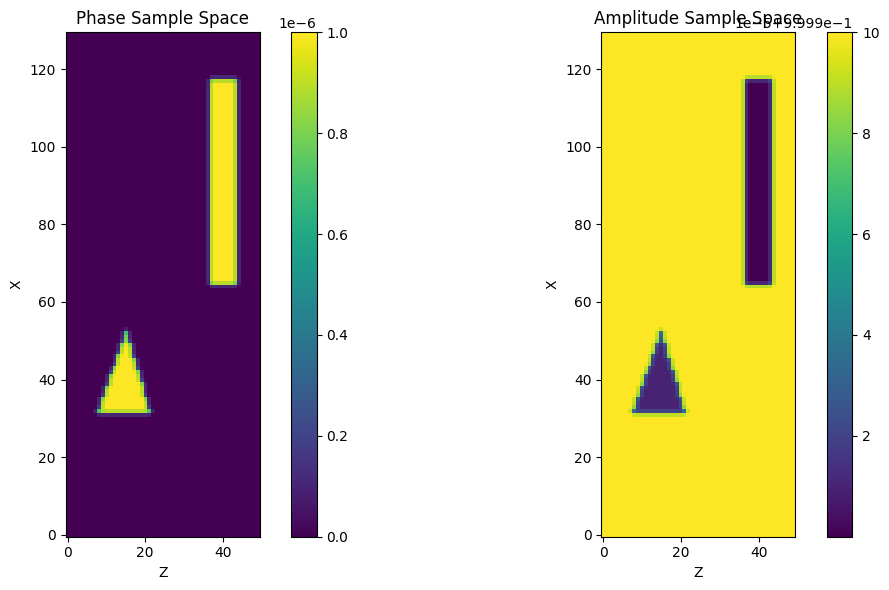

In [12]:
# Visualise the Sample Space
visualisation.plot(solution=sample_space.n_true,title="Sample Space")

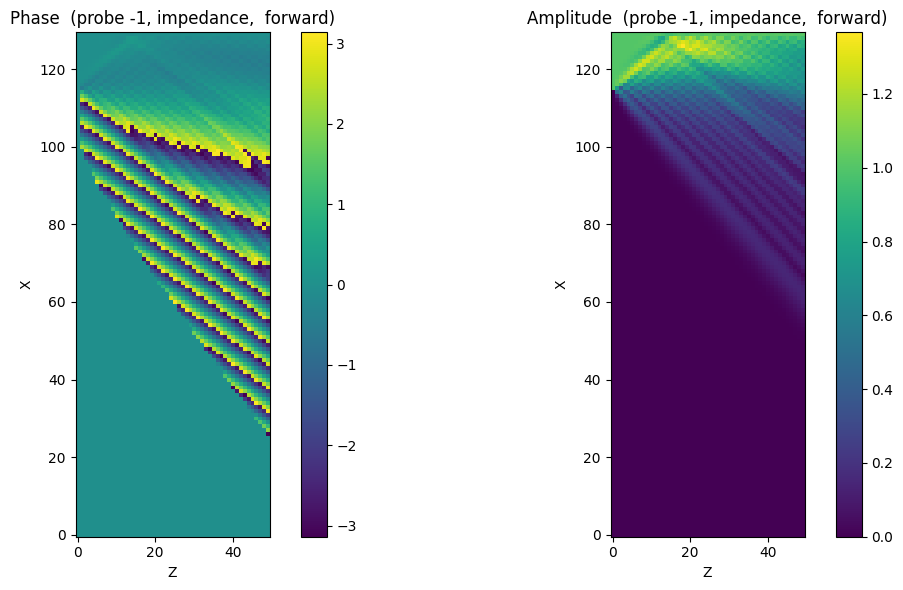

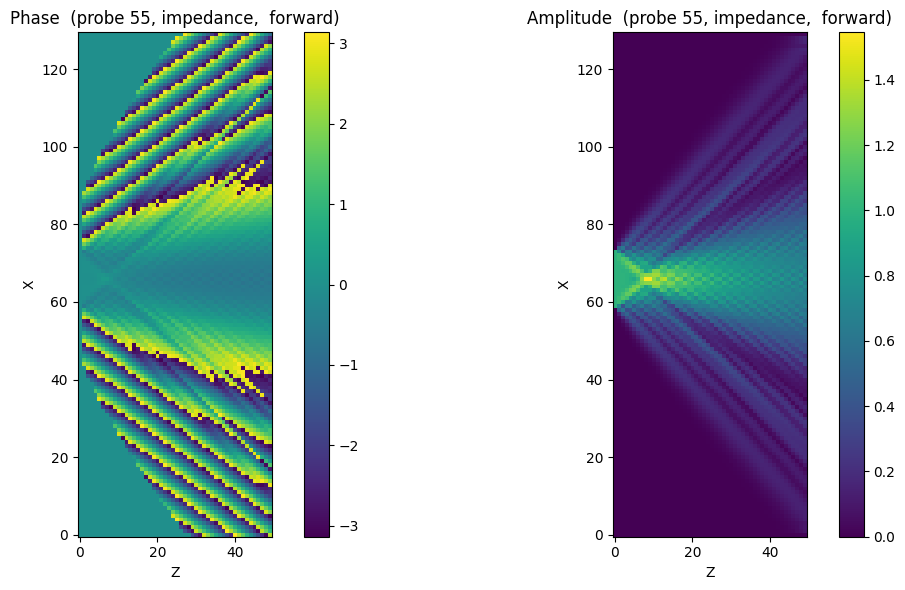

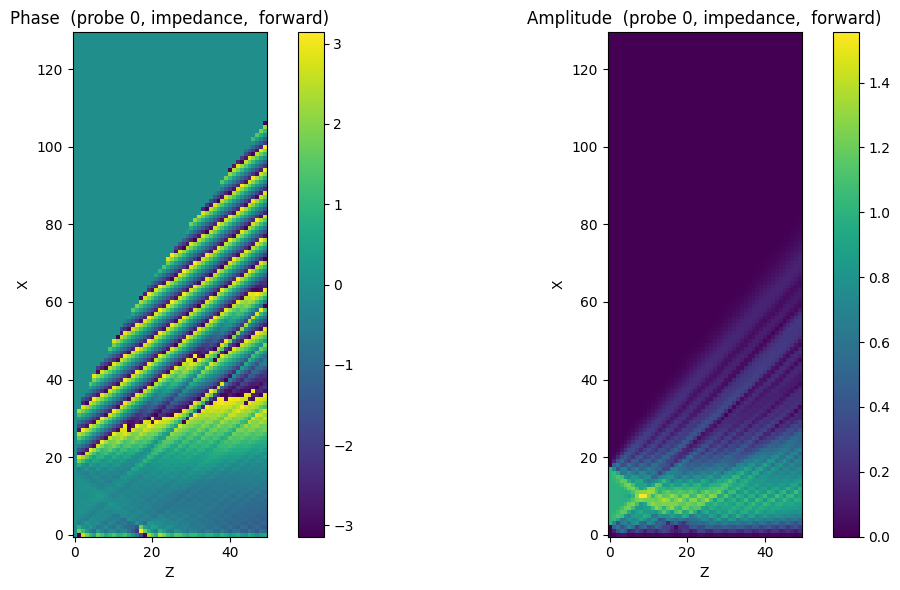

In [13]:
# Plot Solution for Full Sample Solves
visualisation.plot(solution=solution_iterative_full,probe_index=-1)
visualisation.plot(solution=solution_iterative_full)
visualisation.plot(solution=solution_iterative_full,probe_index=0)

### Compare with Homogeneous Sample

In [14]:
sample_space = SampleSpace(
    continuous_dimensions, # sample space dimensions in nanometers (x, z) or (x, y, z)
    discrete_dimensions,   # sample space dimensions in pixels (nx, nz) or (nx, ny, nz)
    probe_dimensions,        # shape of the detector in pixels - subset of (nx) or (nx, ny)
    scan_points,           # number of ptychography scan points or sqrt(scan_points) for square scan
    step_size,
    bc_type,               # boundary condition type (impedance, dirichlet, neumann)
    probe_type,
    wave_number,            # wavenumber in 1/nm
)
sample_space.summarize_sample_space()
sample_space.generate_sample_space()

# Solve Full Space Space, Iterative
forward_model_iterative_full = ForwardModel(sample_space,
                             full_system_solver=False,
                             thin_sample=False)

# Iterative solution
print("Solving iteratively for full sample...")
solution_iterative_full_homogeneous = forward_model_iterative_full.solve()

Summary of the scan (continuous):
    Sample space x: 1500 um
    Sample space z: 5000 um
    Probe Diameter: 174.42 um
    Number of scan points: 110
    Max Overlap: 162.88 um 

Solving iteratively for full sample...


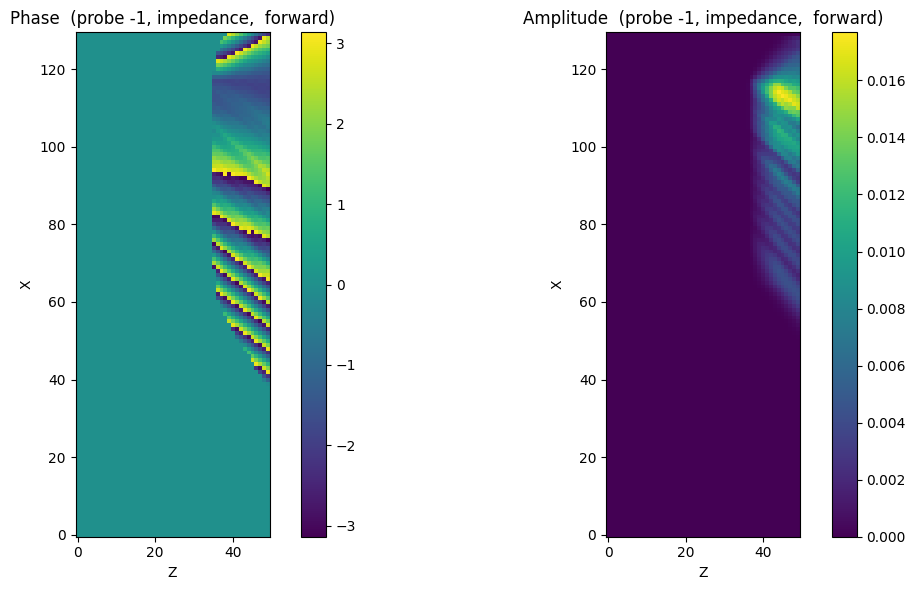

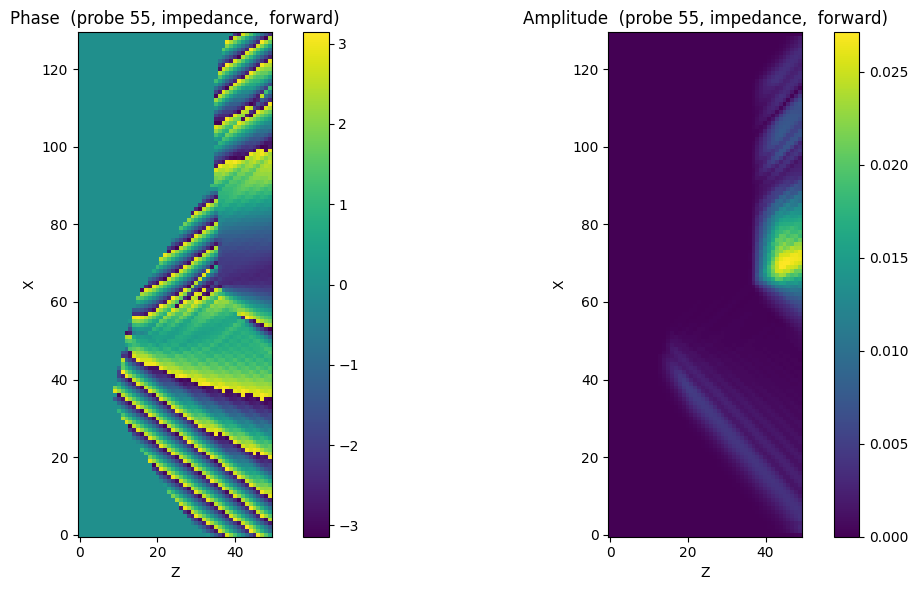

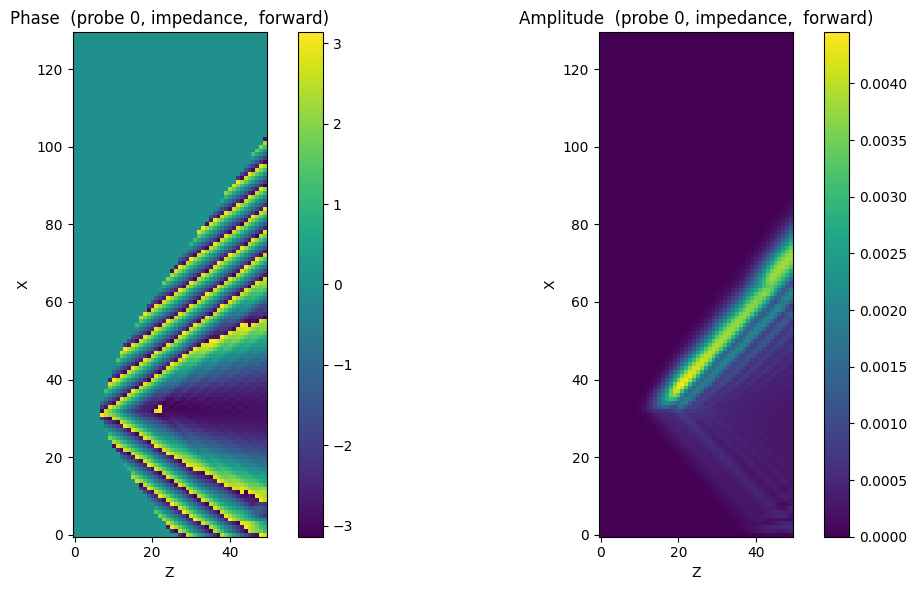

In [15]:
difference = solution_iterative_full_homogeneous - solution_iterative_full
# Plot Solution for Full Sample Solves
visualisation.plot(solution=difference,probe_index=-1)
visualisation.plot(solution=difference)
visualisation.plot(solution=difference,probe_index=0)